## Instalação de Requisitos

In [ ]:
# Lendo o arquivo requisitos.txt
with open('requisitos.txt', 'r') as file:
    requirements = file.readlines()

# Removendo espaços em branco e quebras de linha
requirements = [requirement.strip() for requirement in requirements]

# Instalando as dependências usando pip
!pip3 install -U { ' '.join(requirements) }

## Importando o DataSet e Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


file_path = 'NHANES_age_prediction.csv'
data = pd.read_csv(file_path, header=None)

# Deleta a primeira linha onde está as features
data = data.drop(data.index[0])

# Adiciona os nomes traduzidos ao data_set
names = ['id','grupo_idade','idade','genero','atividade_fisica','imc','glicose_pos_jejum','diabetes','saude_bucal','insulina']
data.columns = names

data.head()

,id,grupo_idade,idade,genero,atividade_fisica,imc,glicose_pos_jejum,diabetes,saude_bucal,insulina
1,73564.0,Adult,61.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
2,73568.0,Adult,26.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85
3,73576.0,Adult,16.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14
4,73577.0,Adult,32.0,1.0,2.0,28.9,104.0,2.0,84.0,16.15
5,73580.0,Adult,38.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92


## Analisando o DATASET
1. Dimensões do dataset
2. Quantidade de valores NULOS
3. Valores UNICOS
4. Estatísticas

In [ ]:
data.shape

In [ ]:
data.isnull().sum()

In [ ]:
for col in data.columns:
    print(f"\nColumn Name: {col}")
    print(data[col].value_counts())

In [ ]:
# Converta todas as colunas para numéricas
dataDescribe = data.apply(pd.to_numeric, errors='coerce')

# Agora você pode usar describe()
dataDescribe.describe()

## Pré-Processamento do DataSet

In [2]:
# Removendo colunas desnecessárias
# Info importante: > 65 anos é considerado idoso e abaixo = Adulto
data = data.drop('id', axis=1)
data = data.drop('idade', axis=1)

# Transformando a feature grupo_idade(Nosso objetivo) em binário (ou numérico) [Adulto = 0, Idoso = 1]
data['grupo_idade'] = data['grupo_idade'].replace({'Adult': 0, 'Senior': 1})

# Garantindo que todos os dados estão realmente sendo tratados como numéricos
data = data.apply(pd.to_numeric, errors='coerce')

# Adicionar nome das colunas ao para a variável feature_names
data.feature_names = [data.columns]

# Leitura dataset para verificar
data.head()

C:\Users\pc\AppData\Local\Temp\ipykernel_16260\3998405378.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['grupo_idade'] = data['grupo_idade'].replace({'Adult': 0, 'Senior': 1})
C:\Users\pc\AppData\Local\Temp\ipykernel_16260\3998405378.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.feature_names = [data.columns]


,grupo_idade,genero,atividade_fisica,imc,glicose_pos_jejum,diabetes,saude_bucal,insulina
1,0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
2,0,2.0,2.0,20.3,89.0,2.0,80.0,3.85
3,0,1.0,2.0,23.2,89.0,2.0,68.0,6.14
4,0,1.0,2.0,28.9,104.0,2.0,84.0,16.15
5,0,2.0,1.0,35.9,103.0,2.0,81.0,10.92


In [ ]:
data.head()

Testando o melhor método para identificar outliers
1. método IQR (Interquartile Range)

In [ ]:
# Método IQR para identificar e tratar outliers

# Calcular Q1, Q3 e IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Determinar os limites inferior e superior para identificar outliers
lower_bound = Q1 - 3.0 * IQR
upper_bound = Q3 + 3.0 * IQR

# Identificar outliers
outliers = (data < lower_bound) | (data > upper_bound)

# Tratar os outliers (remover ou substituir)
data_tratada = data[~outliers.any(axis=1)]

# Exibir os outliers encontrados
print("Outliers identificados:")
print(data[outliers.any(axis=1)])

#Exibir os dados tratados (sem outliers)
print("\nDados tratados:")
print(data_tratada)

2. Z-Score method

In [3]:
# Teste de tratamento de dados com Z-Score
# Calcular o Z-score para cada ponto de dados
z_scores = stats.zscore(data)

# Determinar o limite de corte para identificar outliers (por exemplo, 3 desvios padrão)
# Após testes 5.6 foi o melhor valor encontrado para o threshold devido aos diabetes 1 e 3, que em threshholds menores são excluídos, talvez em um dataset maior seja possível encontrar um valor melhor
threshold = 5.6

# Identificar outliers
outliers = (abs(z_scores) > threshold).any(axis=1)

# Tratar os outliers (remover ou substituir)
data_tratada = data[~outliers]

# Exibir os outliers encontrados
print("Outliers identificados:")
print(data[outliers])

# Exibir os dados tratados (sem outliers)
print("\nDados tratados:")
print(data_tratada)

Outliers identificados:
      grupo_idade  genero  atividade_fisica   imc  glicose_pos_jejum  \
209             0     2.0               2.0  29.1              297.0   
213             1     1.0               2.0  44.6              208.0   
248             0     1.0               1.0  41.0               95.0   
292             0     2.0               2.0  68.6               91.0   
414             0     1.0               7.0  21.1              110.0   
610             0     2.0               2.0  29.0              250.0   
784             0     1.0               2.0  34.7               94.0   
815             0     2.0               2.0  70.1               95.0   
819             0     2.0               2.0  28.6              257.0   
893             0     1.0               1.0  43.4              103.0   
953             0     1.0               2.0  37.3              275.0   
1069            0     2.0               2.0  34.0              210.0   
1116            0     1.0               

3. Comandos para testar se é utilizável ou não

In [ ]:
data_tratada.describe()
#mean -> média dos valores na coluna
#std -> desvio padrão dos valores na coluna

In [ ]:
data_tratada.shape

In [4]:
for col in data_tratada.columns:
    print(f"\nColumn Name: {col}")
    print(data_tratada[col].value_counts())


Column Name: grupo_idade
grupo_idade
0    1895
1     363
Name: count, dtype: int64

Column Name: genero
genero
2.0    1157
1.0    1101
Name: count, dtype: int64

Column Name: atividade_fisica
atividade_fisica
2.0    1852
1.0     406
Name: count, dtype: int64

Column Name: imc
imc
23.9    26
23.7    24
27.4    22
25.8    22
24.2    21
        ..
50.6     1
50.3     1
37.8     1
39.3     1
48.0     1
Name: count, Length: 337, dtype: int64

Column Name: glicose_pos_jejum
glicose_pos_jejum
96.0     119
94.0     117
99.0     106
100.0    102
97.0      98
        ... 
159.0      1
72.0       1
142.0      1
139.0      1
158.0      1
Name: count, Length: 89, dtype: int64

Column Name: diabetes
diabetes
2.0    2185
3.0      57
1.0      16
Name: count, dtype: int64

Column Name: saude_bucal
saude_bucal
91.0     43
100.0    40
94.0     39
90.0     36
103.0    36
         ..
241.0     1
250.0     1
201.0     1
318.0     1
208.0     1
Name: count, Length: 221, dtype: int64

Column Name: insulina
i

Baseado nos valores, médios podemos confirmar que a melhor alternativa nesse caso será Z-Index com 3 desvios padrão, Então devemos dividir os valores em teste e treino

In [5]:
data = data_tratada

# Separando nosso objetivo dos dados explicativos, sendo Y o target e X os dados explicativos
x = data.drop('grupo_idade', axis=1)
y = data['grupo_idade']

# Dividindo os dados em Treino e Teste (30% para teste)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3)

## Criando Máquina Preditiva
1. Algoritmo "Decision Tree"

In [ ]:
# Algoritmo "Decision Tree"
maquina_preditiva = tree.DecisionTreeClassifier(max_depth=10)
# OBS = Decision Tree acertou ~76.1% dos casos

# Treinando com os dados de treino
maquina_preditiva.fit(X_train, Y_train)

2. Algoritmo "Random Forest"

In [10]:
# Algoritmo "Random Forest"

maquina_preditiva = RandomForestClassifier(n_estimators=1000)
# OBS = Random Forest acertou ~83.4% dos casos (melhor resultado)
# OBS.2 = Com o hiperparametro diferenes o resultado foi de ~85.25% de acerto (e se manteve em maioria dos casos testados)

# Treinando com os dados de treino
maquina_preditiva.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=1000)

3. Algoritmo "k-nearest neighbors"

In [ ]:

# Algoritmo "k-nearest neighbors"

maquina_preditiva = KNeighborsClassifier(n_neighbors=5)
# OBS: O número de vizinhos (n_neighbors) pode ser ajustado para obter melhores resultados

# Treinando com os dados de treino
maquina_preditiva.fit(X_train, Y_train)


In [11]:
# Testando a máquina preditiva com dados de teste
Valor_predito = maquina_preditiva.predict(X_test)
print(Valor_predito)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

## Avaliação da acurácia

In [ ]:
# Avaliando a acurácia
print (((accuracy_score(Valor_predito, Y_test)))*100)

1. Validação cruzada com K-Fold

In [9]:
# Configuração da validação cruzada com k-Fold
k_fold = 5

# Algoritmos a serem avaliados
algoritmos = {
    "Decision Tree": tree.DecisionTreeClassifier(max_depth=10),
    "Random Forest": RandomForestClassifier(n_estimators=1000),
    "k-nearest neighbors": KNeighborsClassifier(n_neighbors=5)
}

# Avaliação dos algoritmos com validação cruzada
for nome, algoritmo in algoritmos.items():
    scores = cross_val_score(algoritmo, x, y, cv=k_fold)
    print(f"{nome}: Acurácia média = {scores.mean() * 100:.2f}% (+/- {scores.std() * 2 * 100:.2f}%)")

Decision Tree: Acurácia média = 80.07% (+/- 2.52%)
Random Forest: Acurácia média = 84.14% (+/- 0.74%)
k-nearest neighbors: Acurácia média = 82.15% (+/- 1.88%)


2. Métricas F1-Score para avaliação de underfitting ou overfitting

In [12]:
from sklearn.metrics import f1_score

# Calculando o F1-Score
f1 = f1_score(Y_test, Valor_predito, average='weighted')

# Exibindo o F1-Score
print(f"F1-Score: {f1}")

F1-Score: 0.7893639186470363


## Apresentação de resultados através de gráficos e tabelas

                Método  Acurácia  F1-Score
0        Decision Tree     0.761     0.761
1        Random Forest     0.841     0.789
2  k-nearest neighbors     0.823     0.823


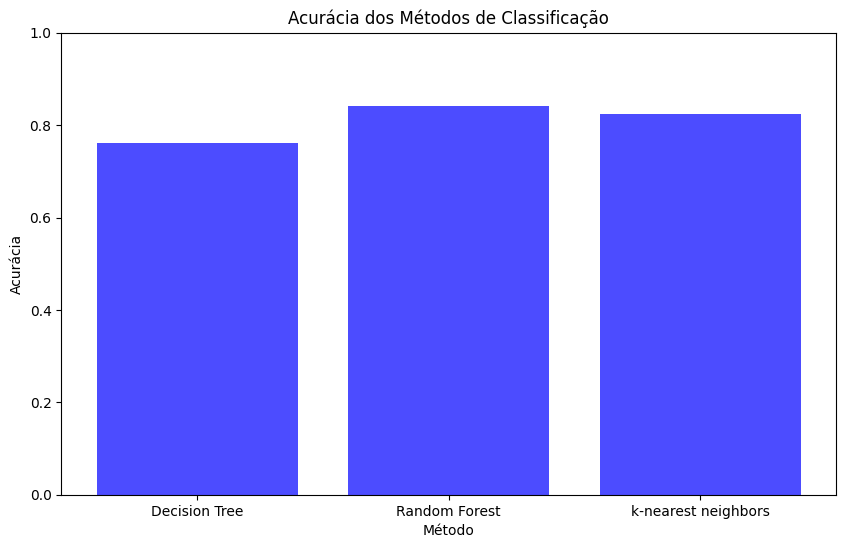

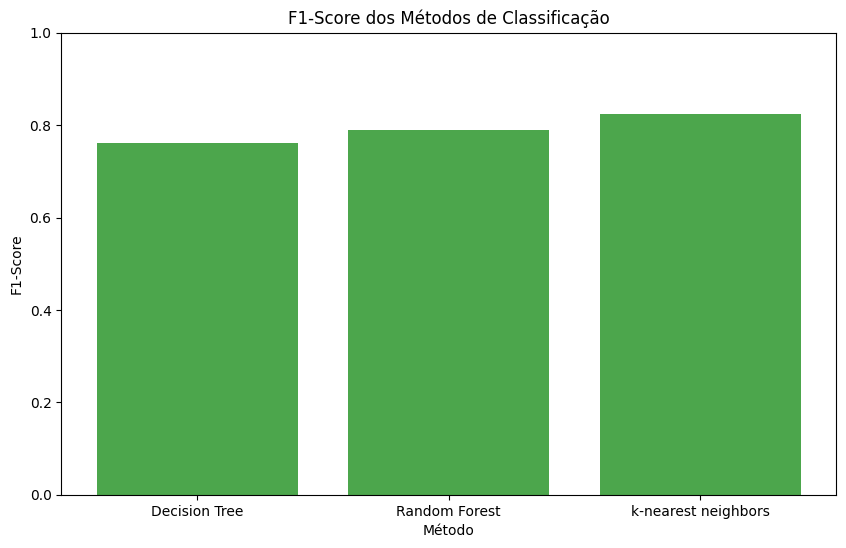

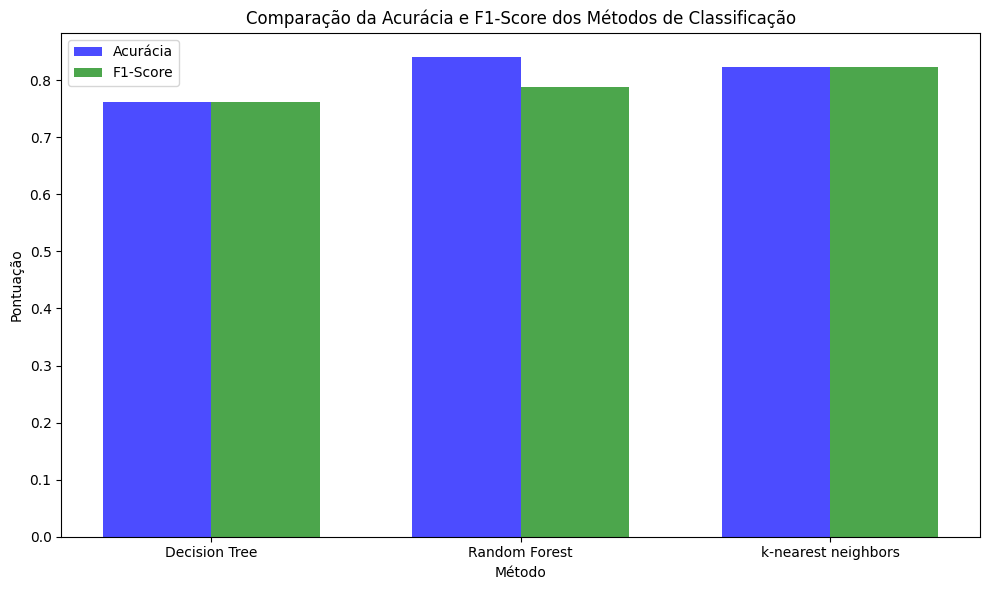

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Dados dos resultados
resultados = {
    'Método': ['Decision Tree', 'Random Forest', 'k-nearest neighbors'],
    'Acurácia': [0.761, 0.841, 0.823],  # Exemplo de valores
    'F1-Score': [0.761, 0.789, 0.823]  # Exemplo de valores
}

# Criando um DataFrame para os resultados
df_resultados = pd.DataFrame(resultados)

# Exibindo a tabela de resultados
print(df_resultados)

# Gráfico de barras para a Acurácia
plt.figure(figsize=(10, 6))
plt.bar(df_resultados['Método'], df_resultados['Acurácia'], color='blue', alpha=0.7)
plt.title('Acurácia dos Métodos de Classificação')
plt.xlabel('Método')
plt.ylabel('Acurácia')
plt.ylim(0, 1)
plt.show()

# Gráfico de barras para o F1-Score
plt.figure(figsize=(10, 6))
plt.bar(df_resultados['Método'], df_resultados['F1-Score'], color='green', alpha=0.7)
plt.title('F1-Score dos Métodos de Classificação')
plt.xlabel('Método')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.show()

# Configurações para o gráfico de barras agrupadas
bar_width = 0.35
index = np.arange(len(df_resultados['Método']))

# Gráfico de barras agrupadas
plt.figure(figsize=(10, 6))
bar1 = plt.bar(index, df_resultados['Acurácia'], bar_width, label='Acurácia', color='blue', alpha=0.7)
bar2 = plt.bar(index + bar_width, df_resultados['F1-Score'], bar_width, label='F1-Score', color='green', alpha=0.7)

# Adicionando detalhes ao gráfico
plt.xlabel('Método')
plt.ylabel('Pontuação')
plt.title('Comparação da Acurácia e F1-Score dos Métodos de Classificação')
plt.xticks(index + bar_width / 2, df_resultados['Método'])
plt.legend()

# Exibindo o gráfico
plt.tight_layout()
plt.show()